<a href="https://colab.research.google.com/github/NancyNi27/722Lab/blob/main/iteration4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## import libraries and initialize spark session
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, desc, approx_count_distinct, countDistinct,log, sqrt
from pyspark.sql import functions as F

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime
import plotly.figure_factory as ff
import plotly.offline as pyo

In [ ]:
#initialize spark session
spark = SparkSession.builder \
    .appName("Data Exploration with PySpark") \
    .getOrCreate()

In [ ]:
##Load Data
data_train = "/content/train.csv"
data_testA = "/content/testA.csv"

data_train = spark.read.csv(data_train, header=True, inferSchema=True)
data_testA = spark.read.csv(data_testA, header=True, inferSchema=True)

In [ ]:
## Data Preprocessing

#check training dataset structure
data_train.printSchema()
data_train.show(5)

#check the size
print("Train data shape:",(data_train.count(),len(data_train.columns)))
print("TestA data shape:",(data_testA.count(),len(data_testA.columns)))

data_train.describe().show()


root
 |-- id: integer (nullable = true)
 |-- loanAmnt: double (nullable = true)
 |-- term: integer (nullable = true)
 |-- interestRate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- subGrade: string (nullable = true)
 |-- employmentTitle: double (nullable = true)
 |-- employmentLength: string (nullable = true)
 |-- homeOwnership: integer (nullable = true)
 |-- annualIncome: double (nullable = true)
 |-- verificationStatus: integer (nullable = true)
 |-- issueDate: date (nullable = true)
 |-- isDefault: integer (nullable = true)
 |-- purpose: integer (nullable = true)
 |-- postCode: double (nullable = true)
 |-- regionCode: integer (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinquency_2years: double (nullable = true)
 |-- ficoRangeLow: double (nullable = true)
 |-- ficoRangeHigh: double (nullable = true)
 |-- openAcc: double (nullable = true)
 |-- pubRec: double (nullable = true)
 |-- pubRecBankruptcies: dou

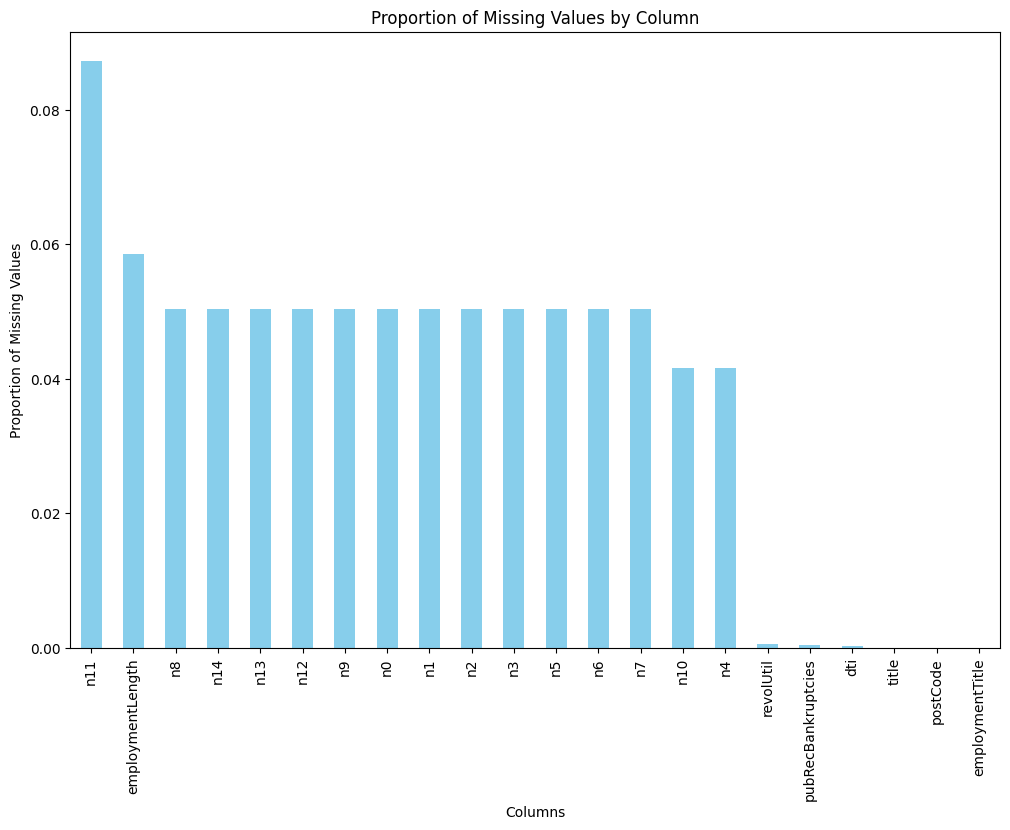

In [ ]:
# visualize the NAN
# caclulate the missing ration
def calculate_missing_ratio(df):
    total_count = df.count()
    missing_ratio = df.select([((count(when(col(c).isNull(), c)) / total_count).alias(c)) for c in df.columns])
    return missing_ratio

# get the proportion of missing values
missing_ratio_df = calculate_missing_ratio(data_train)

# transform into pandas dataframe
missing_ratio_pd = missing_ratio_df.toPandas()
missing_ratio_pd = missing_ratio_pd.transpose()
missing_ratio_pd.columns = ['missing_ratio']
missing_ratio_pd = missing_ratio_pd[missing_ratio_pd['missing_ratio'] > 0]
missing_ratio_pd.sort_values(by='missing_ratio', ascending=False, inplace=True)

# plot a bar chart
plt.figure(figsize=(12, 8))
missing_ratio_pd['missing_ratio'].plot(kind='bar', color='skyblue')
plt.title('Proportion of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Proportion of Missing Values')
plt.show()

In [ ]:
# Numeric and Object Type Characteristics
numeric_features = [t[0] for t in data_train.dtypes if t[1] == 'int' or t[1] == 'double']
object_features = [t[0] for t in data_train.dtypes if t[1] == 'string']

print("Numeric Features:", numeric_features)
print("Object Features:", object_features)

Numeric Features: ['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership', 'annualIncome', 'verificationStatus', 'isDefault', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
Object Features: ['grade', 'subGrade', 'employmentLength', 'earliesCreditLine']


In [ ]:
data_train.select('grade').show(5)

+-----+
|grade|
+-----+
|    E|
|    D|
|    D|
|    A|
|    C|
+-----+
only showing top 5 rows



In [ ]:
def get_numerical_serial_fea(data, feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []

    for fea in feas:
        unique_count = data.agg(approx_count_distinct(col(fea)).alias('distinct_count')).collect()[0]['distinct_count']

        if unique_count <= 10:
            numerical_noserial_fea.append(fea)
        else:
            numerical_serial_fea.append(fea)

    return numerical_serial_fea, numerical_noserial_fea

try:
    numerical_serial_fea, numerical_noserial_fea = get_numerical_serial_fea(data_train, numeric_features)
    print("Serial (Continuous) Numerical Features:", numerical_serial_fea)
    print("NoSerial (Discrete) Numerical Features:", numerical_noserial_fea)
except Exception as e:
    print("An error occurred:", e)

Serial (Continuous) Numerical Features: ['id', 'loanAmnt', 'interestRate', 'installment', 'employmentTitle', 'annualIncome', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'title', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14']
NoSerial (Discrete) Numerical Features: ['term', 'homeOwnership', 'verificationStatus', 'isDefault', 'initialListStatus', 'applicationType', 'policyCode', 'n11', 'n12']


In [ ]:
# count the value
term_counts = data_train.groupBy("term").count()
term_counts.show()

homeOwnership_counts = data_train.groupBy("homeOwnership").count()
homeOwnership_counts.show()

verificationStatus_counts = data_train.groupBy("verificationStatus").count()
verificationStatus_counts.show()

initialListStatus_counts = data_train.groupBy("initialListStatus").count()
initialListStatus_counts.show()

applicationType_counts = data_train.groupBy("applicationType").count()
applicationType_counts.show()

policyCode_counts = data_train.groupBy("policyCode").count()
policyCode_counts.show()

n11_counts = data_train.groupBy("n11").count()
n11_counts.show()

n12_counts = data_train.groupBy("n12").count()
n12_counts.show()

+----+------+
|term| count|
+----+------+
|   3|606902|
|   5|193098|
+----+------+

+-------------+------+
|homeOwnership| count|
+-------------+------+
|            1|317660|
|            3|   185|
|            5|    81|
|            4|    33|
|            2| 86309|
|            0|395732|
+-------------+------+

+------------------+------+
|verificationStatus| count|
+------------------+------+
|                 1|309810|
|                 2|248968|
|                 0|241222|
+------------------+------+

+-----------------+------+
|initialListStatus| count|
+-----------------+------+
|                1|333562|
|                0|466438|
+-----------------+------+

+---------------+------+
|applicationType| count|
+---------------+------+
|              1| 15414|
|              0|784586|
+---------------+------+

+----------+------+
|policyCode| count|
+----------+------+
|       1.0|800000|
+----------+------+

+----+------+
| n11| count|
+----+------+
| 0.0|729682|
|NULL| 69752|
| 

In [ ]:
from pyspark.sql.functions import col, log
# caculate basisc statistics
stats = data_train.select(log(col("loanAmnt")).alias("loanAmnt_log")).summary("count","mean","stddev","min","25%","50%","75%","max")
#pandas dataframe
stats_pd = stats.toPandas()
print(stats_pd)

  summary        loanAmnt_log
0   count              800000
1    mean   9.366847213683226
2  stddev  0.6963523395993501
3     min   6.214608098422191
4     25%   8.987196820661973
5     50%   9.392661928770137
6     75%   9.903487552536127
7     max  10.596634733096073


In [ ]:
# calculate the object values
grade_counts = data_train.groupBy("grade").count().orderBy("grade")
subgrade_counts = data_train.groupBy("subGrade").count().orderBy("subGrade")
employment_length_counts = data_train.groupBy("employmentLength").count().orderBy("employmentLength")
issue_date_counts = data_train.groupBy("issueDate").count().orderBy("issueDate")
earliesCreditLine_counts = data_train.groupBy("earliesCreditLine").count().orderBy("earliesCreditLine")
isDefault_counts = data_train.groupBy("isDefault").count().orderBy("isDefault")

grade_counts.show()
subgrade_counts.show()
employment_length_counts.show()
issue_date_counts.show()
earliesCreditLine_counts.show()
isDefault_counts.show()

+-----+------+
|grade| count|
+-----+------+
|    A|139661|
|    B|233690|
|    C|227118|
|    D|119453|
|    E| 55661|
|    F| 19053|
|    G|  5364|
+-----+------+

+--------+-----+
|subGrade|count|
+--------+-----+
|      A1|25909|
|      A2|22124|
|      A3|22655|
|      A4|30928|
|      A5|38045|
|      B1|42382|
|      B2|44227|
|      B3|48600|
|      B4|49516|
|      B5|48965|
|      C1|50763|
|      C2|47068|
|      C3|44751|
|      C4|44272|
|      C5|40264|
|      D1|30538|
|      D2|26528|
|      D3|23410|
|      D4|21139|
|      D5|17838|
+--------+-----+
only showing top 20 rows

+----------------+------+
|employmentLength| count|
+----------------+------+
|            NULL| 46799|
|          1 year| 52489|
|       10+ years|262753|
|         2 years| 72358|
|         3 years| 64152|
|         4 years| 47985|
|         5 years| 50102|
|         6 years| 37254|
|         7 years| 35407|
|         8 years| 36192|
|         9 years| 30272|
|        < 1 year| 64237|
+---------

In [ ]:
## Data Pre-Processing
# NAN values
from pyspark.sql.functions import col, sum as spark_sum, isnan, when, count
missing_data = data_train.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in data_train.columns]
)
missing_data.show()

+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+------------+------------------+---------+---------+-------+--------+----------+---+------------------+------------+-------------+-------+------+------------------+--------+---------+--------+-----------------+---------------+-----------------+-----+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| id|loanAmnt|term|interestRate|installment|grade|subGrade|employmentTitle|employmentLength|homeOwnership|annualIncome|verificationStatus|issueDate|isDefault|purpose|postCode|regionCode|dti|delinquency_2years|ficoRangeLow|ficoRangeHigh|openAcc|pubRec|pubRecBankruptcies|revolBal|revolUtil|totalAcc|initialListStatus|applicationType|earliesCreditLine|title|policyCode|   n0|   n1|   n2|   n3|   n4|   n5|   n6|   n7|   n8|   n9|  n10|  n11|  n12|  n13|  n14|
+---+--------+----+------------+-----------+-----+--------+---------------+---------

In [ ]:
##fill the NAN
from pyspark.sql.functions import col, lit, when

# Add a default 'isDefault' column to the test set for structural consistency
data_testA = data_testA.withColumn('isDefault', lit(-1))

# Merge the datasets
combined_data = data_train.unionByName(data_testA)

# Fill in numeric features
for col in numeric_features:
    if col in combined_data.columns:
        median_value = combined_data.approxQuantile(col, [0.5], 0.001)[0]
        combined_data = combined_data.na.fill({col: median_value})

# Fill in object features
for col in object_features:
    if col in combined_data.columns:
        mode_value = combined_data.groupBy(col).count().orderBy('count', ascending=False).first()[0]
        combined_data = combined_data.na.fill({col: mode_value})

# Separate the datasets
data_train = combined_data.where(combined_data['isDefault'] != -1)
data_test_a = combined_data.where(combined_data['isDefault'] == -1).drop('isDefault')

In [ ]:
# recaculate the NAN
from pyspark.sql.functions import col, count, when

null_counts = data_train.select([(count(when(col(c).isNull(), c))).alias(c) for c in data_train.columns])

null_counts.show()


+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+------------+------------------+---------+---------+-------+--------+----------+---+------------------+------------+-------------+-------+------+------------------+--------+---------+--------+-----------------+---------------+-----------------+-----+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| id|loanAmnt|term|interestRate|installment|grade|subGrade|employmentTitle|employmentLength|homeOwnership|annualIncome|verificationStatus|issueDate|isDefault|purpose|postCode|regionCode|dti|delinquency_2years|ficoRangeLow|ficoRangeHigh|openAcc|pubRec|pubRecBankruptcies|revolBal|revolUtil|totalAcc|initialListStatus|applicationType|earliesCreditLine|title|policyCode| n0| n1| n2| n3| n4| n5| n6| n7| n8| n9|n10|n11|n12|n13|n14|
+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+------------+------------------+------